# Création d'un dataset d'ordre de lecture sur PubLayNet

In [ ]:
!pip install Unidecode
!pip install fuzzysearch

!pip install elementpath
!pip install lxml 
!pip install graphviz
!pip install pydotplus

In [1]:
!ls ../../edspdf-train/data/publaynet/

dev.json xmls


# Sorting lines based on the xml files

In [56]:
from sort_xml import *
base_dir = '../../edspdf-train/data/publaynet/'

%load_ext autoreload
%autoreload 2

import sys
sys.executable

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/Users/souleymbaye/opt/anaconda3/envs/eds_env/bin/python'

In [9]:
import os

from pathlib import Path
import json

### Load pdf and xml example 

In [23]:
xmls_dir = base_dir + 'xmls/'
dev_path = base_dir + 'dev.json'

with open(Path(dev_path)) as f:
    samples = json.load(f)

# load xml files
xmls_names = {} # {pmc = {xml_fname, pdf_fname}}
for root, directories, files in os.walk(xmls_dir):
    for pmc in directories:
        fdir = xmls_dir + pmc
        for root2, directories2, files2 in os.walk(fdir):
            xml_fname = None
            pdfs_fnames = []
            for file in files2:
                if file.split('.')[-1] == 'nxml':
                    xml_fname = file
                if file.split('.')[-1] == 'pdf':
                    pdfs_fnames.append(file)

            lenghts = [len(pf) for pf in pdfs_fnames]
            # if len(lenghts) == 0:
            #   print(f'fdir ==> {fdir}')

            i_min = np.argmin(lenghts)
            xmls_names[pmc] = {'xml' :xml_fname, 'pdf': pdfs_fnames[i_min], 'page_num': None}
    break
# end load xml files
    
    
for image in samples['images']:
    pmc = image['file_name'].split('_')[0]
    if pmc in xmls_names:
        page_num = int(image['file_name'].split('_')[1].split('.')[0])
        xmls_names[pmc]['page_num'] = page_num


In [25]:
for k,v in xmls_names.items():
    print(f'k: {k} -> v: {v}')
    break

k: PMC1253713 -> v: {'xml': 'ehp0113-000073.nxml', 'pdf': 'ehp0113-000073.pdf', 'page_num': 3}


## Model extractor

In [26]:
from edspdf import Pipeline
from edspdf.structures import Box, PDFDoc
from edspdf.visualization.annotations import show_annotations

# model
model = Pipeline()
model.add_pipe("pdfminer-extractor", config=dict(extract_style="true"), name="extractor")

In [99]:
# SUITE TO DO
file_dir = base_dir + 'xmls/PMC1247606'
pdf_path, xml_path = get_paths(file_dir = file_dir)
print(f'xml path: {xml_path}\npdf path: {pdf_path}')


xml path: ../../edspdf-train/data/publaynet/xmls/PMC1247606/ehp0112-001447.nxml
pdf path: ../../edspdf-train/data/publaynet/xmls/PMC1247606/ehp0112-001447.pdf


In [44]:
dict_page_text_boxes[4]

[TextBox(x0=0.5625459150326797, x1=0.9215857843137255, y0=0.03948244949494939, y1=0.05463396464646464, label=None, page_num=4, text='Article | Benefits of attaining the 8-hr ozone standard', props=[TextProperties(italic=False, bold=False, begin=0, end=55, fontname='BMGMCI+Frutiger-Light')]),
 TextBox(x0=0.0784313725490196, x1=0.34640116339869315, y0=0.08215277777777785, y1=0.09414772727272736, label=None, page_num=4, text='We then used a ﬁxed-effects pooling procedure', props=[TextProperties(italic=False, bold=False, begin=0, end=45, fontname='BMGLDK+AGaramond-Regular')]),
 TextBox(x0=0.3660145343137255, x1=0.6339645490196077, y0=0.08217316919192064, y1=0.09416811868687014, label=None, page_num=4, text='function derived from Ostro and Rothschild', props=[TextProperties(italic=False, bold=False, begin=0, end=42, fontname='BMGLDK+AGaramond-Regular')]),
 TextBox(x0=0.6535954738562091, x1=0.9215819983660132, y0=0.08217228535353671, y1=0.09416723484848621, label=None, page_num=4, text='Supp

#### Display XML

Page num 0


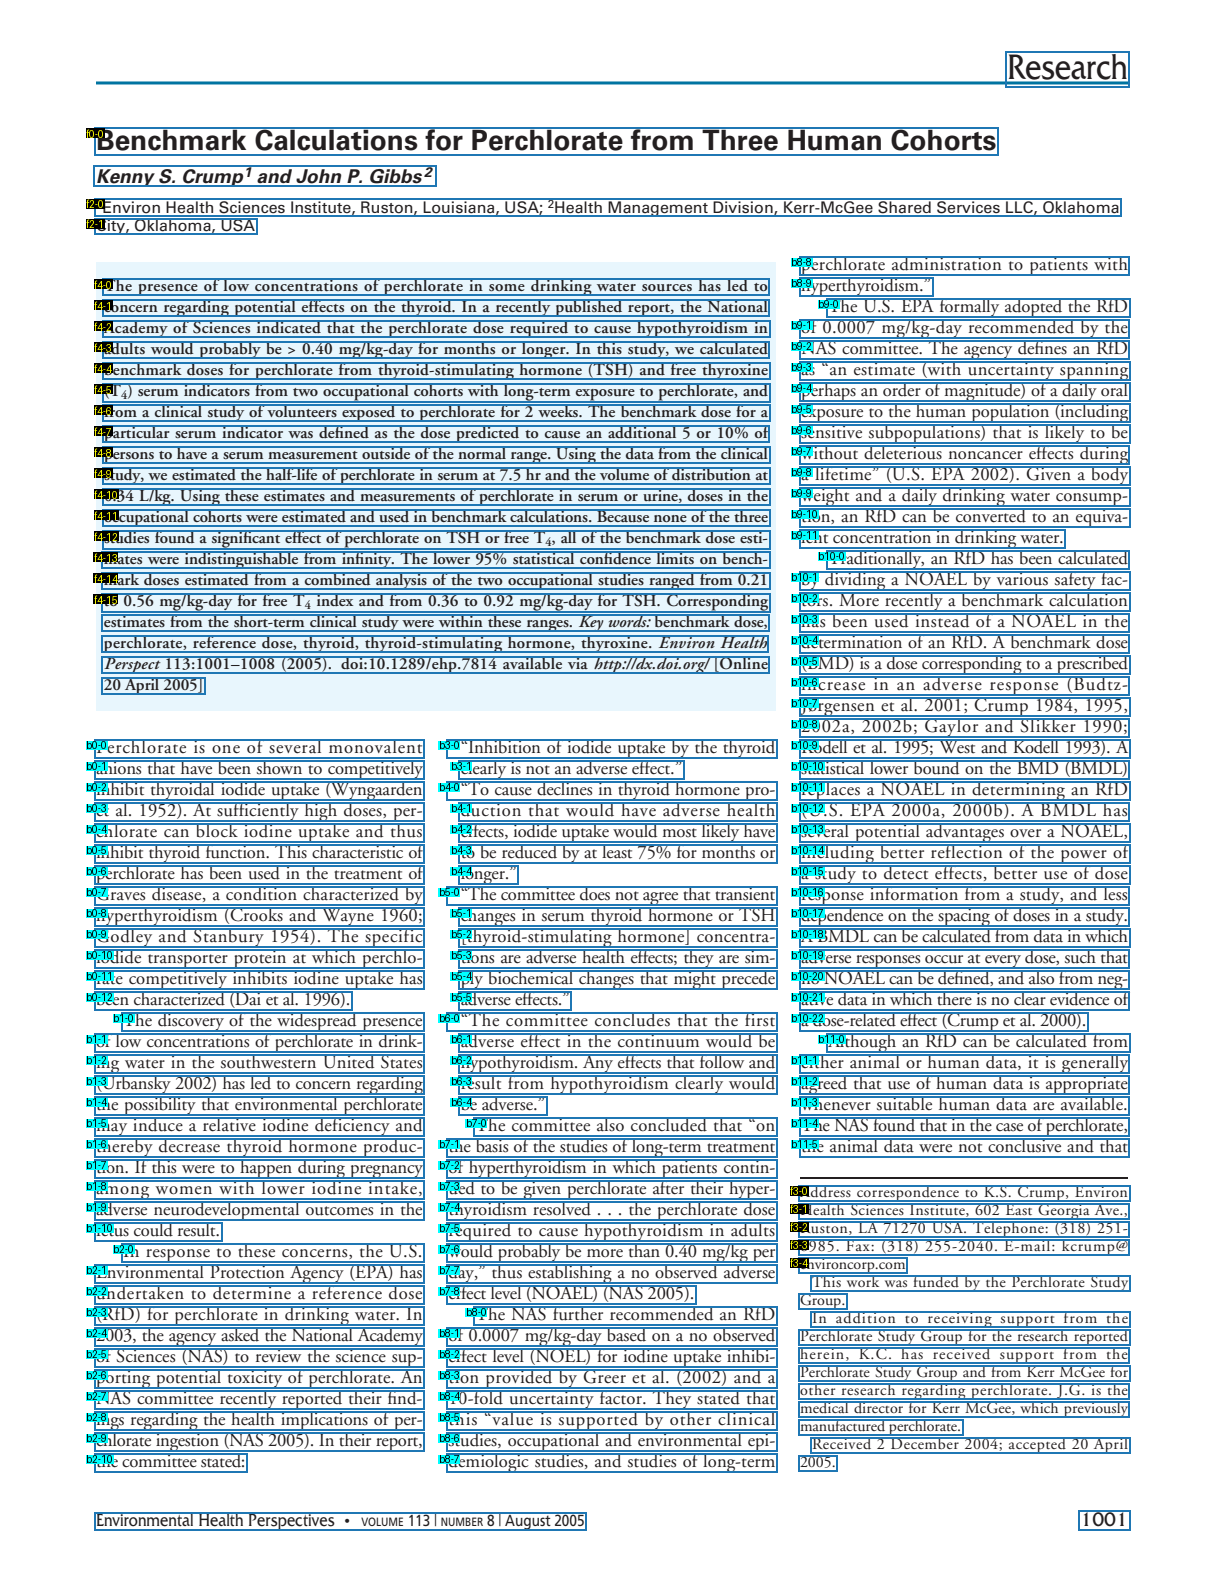

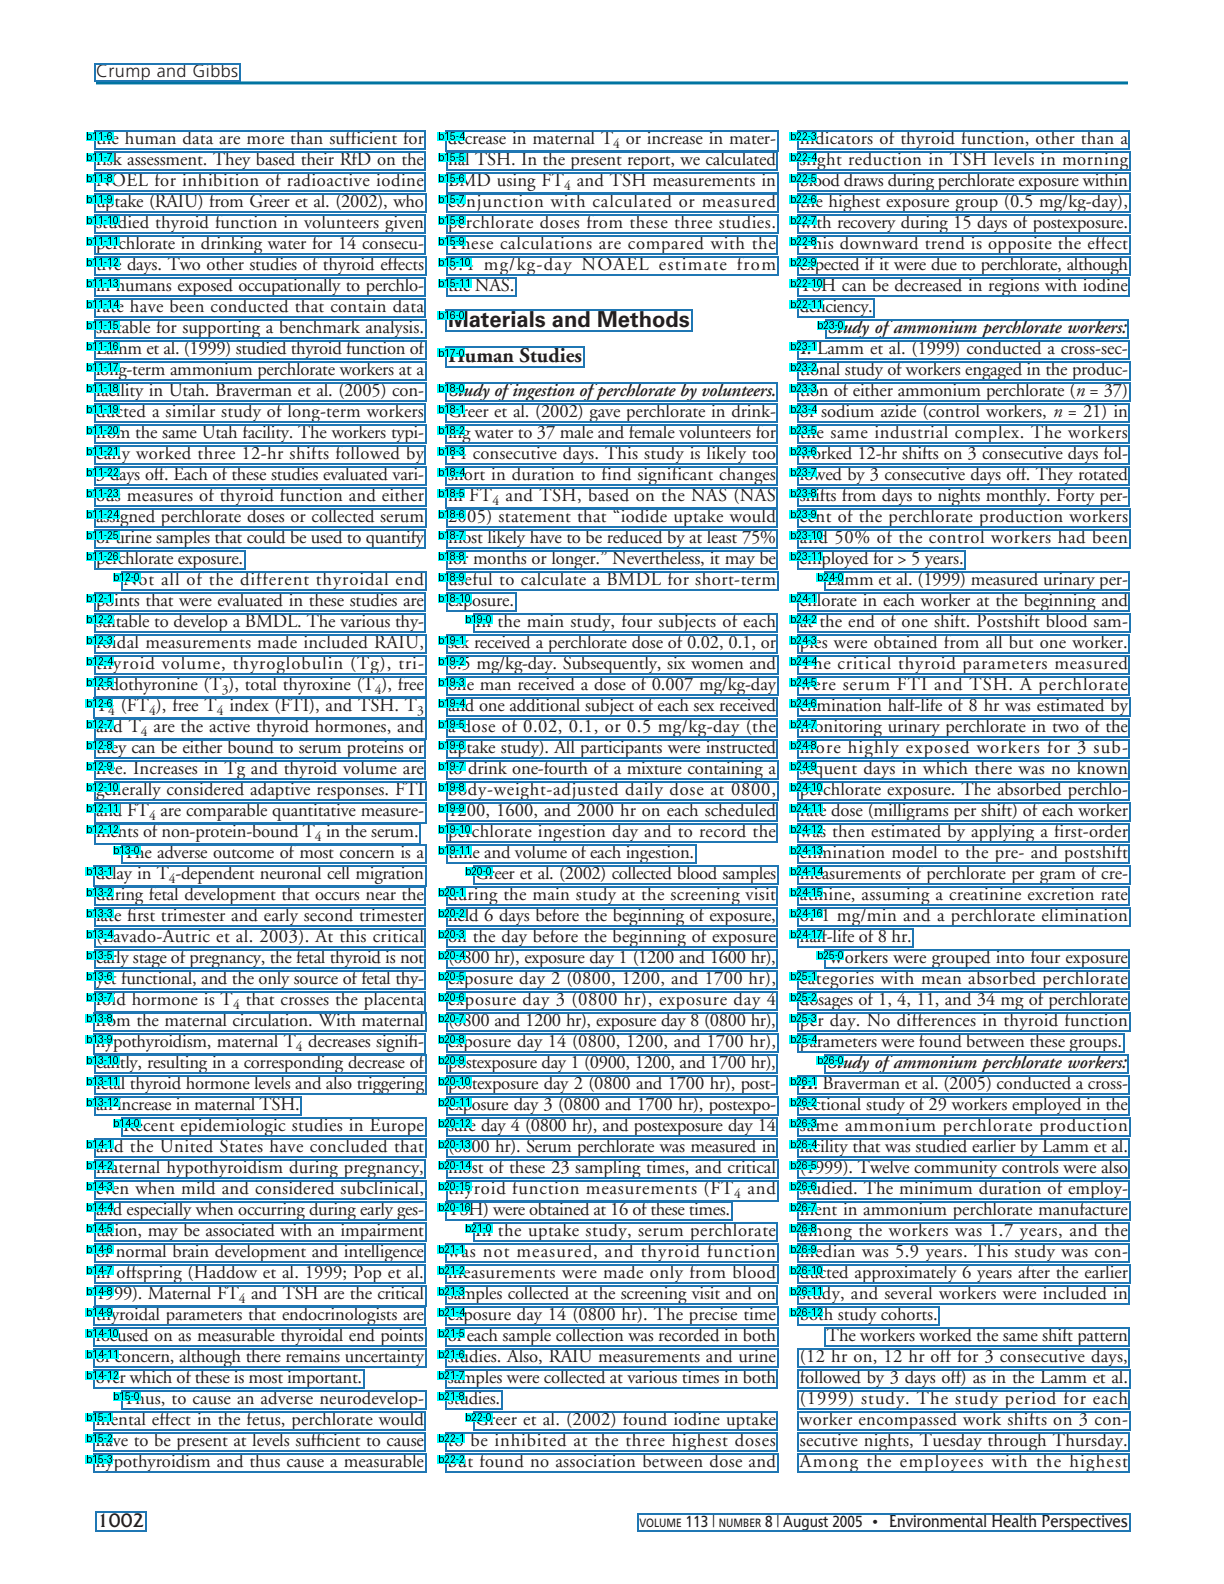

In [61]:
k = 6
for pmc in xmls_names:
    k -= 1
    if k>0: continue
    
    pdf_path = xmls_dir + pmc + '/' + xmls_names[pmc]['pdf']
    xml_path = xmls_dir + pmc + '/' + xmls_names[pmc]['xml']
    page_num = xmls_names[pmc]['page_num']
    
    # Read PDF
    pdf = Path(pdf_path).read_bytes()
    doc: PDFDoc = model.get_pipe("extractor")(pdf)

    _pages_num = [page_num-1, page_num, page_num+1]
    if page_num == 0:
        _pages_num = _pages_num[1:]
    dict_page_text_boxes = {page_num-1: [], page_num: [], page_num+1: []}
    for tb in doc.content_boxes:
        if tb.page_num in _pages_num: # == page_num: # just one page
            dict_page_text_boxes[tb.page_num].append(tb)
            tb.rank = None
            tb.inode = None
    # id des tbs de la page page_num
    for id,tb in enumerate(dict_page_text_boxes[page_num]):
        tb.id = id


    # Read XML
    xml = open(xml_path, 'rb')
    tree = etree.parse(xml)
    # root = tree.getroot()

    
    print(f'Page num {page_num}')
    # front nodes matching
    if page_num == 0:
        xml_front_nodes = get_front_nodes(tree) # xml nodes
        front_nodes = []
        for id,xml_node in enumerate(xml_front_nodes):
            node = Node(xml_node, id, color='yellow', bg_color='black', r0='f', entropie_threshold=0.1)
            front_nodes.append(node)
        # front_nodes = tqdm(front_nodes, mininterval=1)
        get_matches(front_nodes, dict_page_text_boxes, v=False)
        for node in front_nodes:
            if node.full:
                node.bloc.filter_bloc(page_num) 
    # end front nodes matching
    
    
    # body nodes matching
    xml_body_nodes = get_body_nodes(tree)   # xml nodes
    body_nodes = []
    for id, xml_node in enumerate(xml_body_nodes):
        node = Node(xml_node, id, color='black', bg_color='cyan', r0='b')
        body_nodes.append(node)
    # body_nodes = tqdm(body_nodes, mininterval=1)
    get_matches(body_nodes, dict_page_text_boxes, v=False)
    for node in body_nodes:
        if node.full:
            node.bloc.filter_bloc(page_num) 
    # end get body nodes matching
    
    
    # tables nodes matching
    xml_table_nodes = get_tables_nodes(tree)    # xml nodes
    table_nodes = []
    for itable,xml_t in enumerate(xml_table_nodes):
        t_nodes = []
        for id,xml_node in enumerate(xml_t):
            node = Node(xml_node, id, color='red', bg_color='white', r0=f't{itable}-')
            t_nodes.append(node)
        # t_nodes = tqdm(t_nodes, mininterval=1)
        table_nodes.append(t_nodes)
    for t_nodes in table_nodes:
        get_matches(t_nodes, dict_page_text_boxes, v=False)
        for node in front_nodes:
            if node.full:
                node.bloc.filter_bloc(page_num) 
    # end get tables nodes matching
    
    
    
    # Affichage
    pages = [page for page in show_annotations(doc.content, doc.content_boxes)]
    for p in _pages_num:
        display(pages[p])
    # printXML(tree)
    
    
    break

In [62]:
body_nodes[11].print_node()

Nb blocs 5
Node (11 complete) text: `Although an RfD can be calculated from either animal or human data, it is generally agreed that use of human data is appropriate whenever suitable human data are available. The NAS found that in the case of perchlorate, the animal data were not conclusive and that the human data are more than sufficient for risk assessment. They based their RfD on the NOEL for inhibition of radioactive iodine uptake (RAIU) from  Greer et al. (2002) , who studied thyroid function in volunteers given perchlorate in drinking water for 14 consecutive days. Two other studies of thyroid effects in humans exposed occupationally to perchlorate have been conducted that contain data suitable for supporting a benchmark analysis.  Lamm et al. (1999)  studied thyroid function of long-term ammonium perchlorate workers at a facility in Utah.  Braverman et al. (2005)  conducted a similar study of long-term workers from the same Utah facility. The workers typically worked three 12-h

In [63]:
pmc

'PMC1280340'